In [1]:
import pandas
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix as cm
import timeit
from sklearn import svm
from sklearn.metrics import hinge_loss

%matplotlib inline

pathToDataset = "processed.cleveland.data.txt"
columns_names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalac','exang','oldpeak','slope','ca','thal','num']
data = pandas.read_csv(pathToDataset, sep=",",encoding="utf8",names=columns_names)
data.tail(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
293,63.0,1.0,4.0,140.0,187.0,0.0,2.0,144.0,1.0,4.0,1.0,2.0,7.0,2
294,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
295,41.0,1.0,2.0,120.0,157.0,0.0,0.0,182.0,0.0,0.0,1.0,0.0,3.0,0
296,59.0,1.0,4.0,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [2]:
# Create features matrix and results vector
X = data.iloc[:,:(data.shape[1]-1)]
y= data.iloc[:,data.shape[1]-1]

# Distinct values of the predicted variable (num)
y_classes = np.unique(y)

Replacing missing values with mean's column

In [3]:
check_missing=X.apply(lambda x : x.apply(lambda z : str(z)=='?'))
missing_row_indexes, missing_column_indexes = np.where(check_missing==True)

for column in np.unique(missing_column_indexes) :
    rows_to_remove = np.where(missing_column_indexes==column)
    a = pandas.Series(np.arange(0,X.shape[0])).isin(missing_row_indexes[rows_to_remove])
    column_without_missing=X.iloc[:,column][~a]
    mean=np.mean(pandas.Series(column_without_missing,dtype='float'))
    X.iloc[missing_row_indexes[rows_to_remove],column] = np.repeat(mean,len(missing_row_indexes[rows_to_remove]))


Let's define our weak learner function, which is a Decision tree classifier :

In [4]:
def weak_learner(X, y, class_weights, sample_weights,cv=1):
    decision_tree = DecisionTreeClassifier(max_depth=4,class_weight=class_weights)
    fit_params = {'sample_weight' : sample_weights}
    decision_tree.fit(X,y,sample_weight=sample_weights)
    y_predicted = decision_tree.predict(X)
    #y_predicted = cross_val_predict(decision_tree, X,y, cv=cv, fit_params=fit_params)
    return(y_predicted)

AdaBoost.M1 core function :

$ w_i^{t+1} = w_i^t \beta^{1 - h_t(x_i) y_i} =  w_i^t e^{log(\beta)(1 - [\![ h_t(x_i)\neq y_i) ]\!]) } $

In [5]:
def adaboost_m1(X,y,w_t,t,T):
    p.iloc[:,t]= np.array(w_t)/(np.sum(w_t))
    y_predicted.iloc[:,t] = weak_learner(X,y,class_weights,np.array(p.iloc[:,t]))
    
    # Error computation at step t
    error = zero_one_loss(y_predicted.iloc[:,t],y,sample_weight=(p.iloc[:,t].tolist()))
    
    if error <= 0.5 :
        beta[t] = error/(1-error)
        
        # Error computation of the final hypothesis 
        y_final_predicted = compute_final_hypothesis(y_predicted.iloc[:,range(t+1)],y_classes,beta[range(t+1)])
        final_error[t] = zero_one_loss(y_final_predicted,y)
        print('final error : ', final_error[t])
    
        w_t = w_t* (np.exp((1-abs(np.sign(y_predicted.iloc[:,t] - y)))*np.log(beta[t])))
        if t<T :
            return(adaboost_m1(X,y,w_t,t+1,T))
        else :
            return(T)
    else :
        return(t)

In [6]:
def compute_final_hypothesis(y_predicted,y_classes,beta):
    h=pandas.DataFrame(columns=y_classes)
    for y_class in y_classes :
        h.iloc[:,y_class] = np.sum(np.log(1/beta)*(y_predicted == y_class) ,axis=1)
    hf= h.idxmax(axis=1)
    return(hf)

Adaboost.M1 parameters Initialization :

In [7]:
class_weights ={}
for i in y_classes :
    class_weights[i]= 1/ len(y_classes)
#Max number of iterations
T=200
t=0
beta = np.zeros(T)
p = pandas.DataFrame(columns=range(T))
y_predicted = pandas.DataFrame(columns=range(T))

w_t = np.ones_like(y) / len(y)
final_error = np.zeros(T)

Let's launch the AdaBoost.M1 algorithm on the provided data :

In [8]:
t_max=adaboost_m1(X,y,w_t,t,T)

# Dropping all useless columns (steps not computed)
y_predicted = y_predicted.iloc[:,np.arange(0,t_max)]
beta = beta[np.arange(0,t_max)]
final_error = final_error[np.arange(0,t_max)]
print("Number of iterations : ",t_max +1)


final error :  0.293729372937
final error :  0.293729372937
final error :  0.273927392739
final error :  0.273927392739
final error :  0.273927392739
final error :  0.260726072607
final error :  0.244224422442
Number of iterations :  8


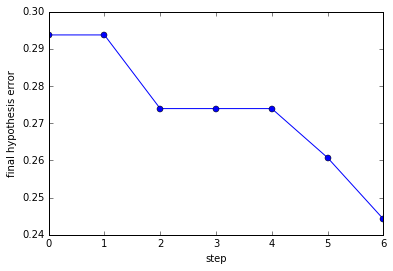

In [56]:
plt.plot(final_error,'-o')
plt.ylabel('final hypothesis error')
plt.xlabel('step')

### Cas binaire :

In [16]:
y[y !=0]=1
y_classes = np.unique(y)

c:\users\wymeka\documents\python\python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
class_weights ={}
for i in y_classes :
    class_weights[i]= 1/ len(y_classes)
#Max number of iterations
T=200
t=0
beta = np.zeros(T+1)
p = pandas.DataFrame(columns=range(0,T+1))
y_predicted = pandas.DataFrame(columns=range(0,T+1))

w_t = np.ones_like(y) / len(y)
final_error = np.zeros(T+1)

In [29]:
t_max=adaboost_m1(X,y,w_t,t,T)

# Dropping all useless columns (steps not computed)
y_predicted = y_predicted.iloc[:,np.arange(0,t_max)]
beta = beta[np.arange(0,t_max)]
final_error = final_error[np.arange(0,t_max)]
print("Number of iterations : ",t_max +1)

final error :  0.125412541254
final error :  0.125412541254
final error :  0.042904290429
final error :  0.042904290429
final error :  0.019801980198
final error :  0.016501650165
final error :  0.003300330033
final error :  0.00660066006601
final error :  0.003300330033
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final error :  0.0
final 

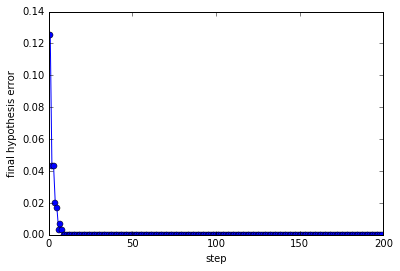

In [30]:
plt.plot(final_error,'-o')
plt.ylabel('final hypothesis error')
plt.xlabel('step')